Processing files...

Reading and transposing: DiD_BCF_ATE_and_PValues_ATE_linearity=1.csv
Transforming P-Values for: DiD_BCF_ATE_and_PValues_ATE_linearity=1.csv
Reading and transposing: did_dr_ATE_and_PValueslinearity_degree=1.csv
Reading and transposing: did2s_ATE_and_PValueslinearity_degree=1.csv
Reading and transposing: DoubleML_did_ATE_and_PValueslinearity_degree=1.csv
Reading and transposing: OLS_ATE_and_PValues_ATE_linearity=1.csv
Transforming P-Values for: OLS_ATE_and_PValues_ATE_linearity=1.csv
Reading and transposing: synthdid_ATE_and_PValueslinearity_degree=1.csv

--- Processing Complete ---

Frequency Table (Proportion of P-Values <= 0.05):
DiD_BCF         0.990099
did_dr          0.990000
did2s           1.000000
DoubleML_did    0.862500
OLS             0.990099
synthdid        1.000000
dtype: float64




/tmp/ipykernel_17794/176886650.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='')


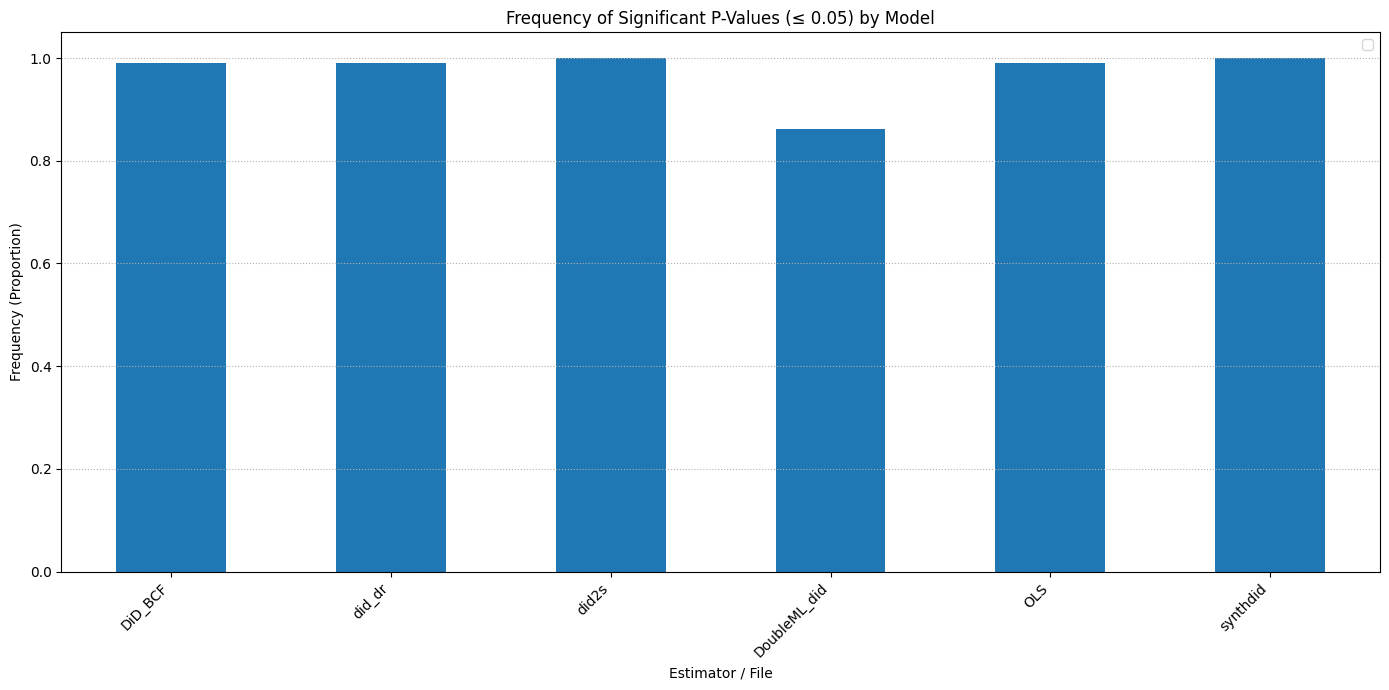

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os # To help with cleaner file names for display

# 0. Define file names and target columns
csv_files = [
    "DiD_BCF_ATE_and_PValues_ATE_linearity=1.csv",
    "did_dr_ATE_and_PValueslinearity_degree=1.csv",
    "did2s_ATE_and_PValueslinearity_degree=1.csv",
    "DoubleML_did_ATE_and_PValueslinearity_degree=1.csv",
    "OLS_ATE_and_PValues_ATE_linearity=1.csv",
    "synthdid_ATE_and_PValueslinearity_degree=1.csv"
]

# Files needing special p-value transformation
transform_files = [
    "DiD_BCF_ATE_and_PValues_ATE_linearity=1.csv",
    "OLS_ATE_and_PValues_ATE_linearity=1.csv"
]

# P-value columns to analyze
p_value_cols_to_analyze = ['PValue_0', 'PValue_1', 'PValue_2', 'PValue_3']

# Dictionary to store results for the final table/graph
frequency_data = {}

# --- Helper function to create cleaner names for display ---
def get_clean_filename(filepath):
    base = os.path.basename(filepath)
    # Remove common suffixes or parts for brevity
    name = base.replace('_ATE_and_PValues_ATE_linearity=1.csv', '')
    name = name.replace('_ATE_and_PValueslinearity_degree=1.csv', '')
    name = name.replace('linearity_degree=1', '') # for DoubleML, did2s, synthdid
    name = name.replace('.csv', '')
    return name

print("Processing files...\n")

# 1. Read and transpose CSVs
for file_path in csv_files:
    try:
        print(f"Reading and transposing: {file_path}")
        # Read the CSV file
        df = pd.read_csv(file_path)
        # Transpose the DataFrame
        df_transposed = df.T
        df_transposed.columns = df_transposed.iloc[0] # Optional: if first row should be header
        # df_transposed = df_transposed[1:]
        # df_transposed = df_transposed.reset_index() # If index is meaningful, otherwise not needed for PValue cols

        # Ensure p-value columns are numeric (they might be read as objects if there are NaNs etc.)
        # And handle cases where PValue columns might not exist in some files after transpose
        # (though the problem implies they should be present)
        for col in p_value_cols_to_analyze:
            if col in df_transposed.columns:
                df_transposed[col] = pd.to_numeric(df_transposed[col], errors='coerce')
            else:
                print(f"Warning: Column {col} not found in transposed {file_path}. Filling with NaNs.")
                df_transposed[col] = pd.NA # Or float('nan')

        # 2. Transform P-Values for specific files
        if file_path in transform_files:
            print(f"Transforming P-Values for: {file_path}")
            for col in p_value_cols_to_analyze:
                if col in df_transposed.columns:
                    # Value > 0.05 becomes 0, otherwise (<= 0.05) becomes 1
                    df_transposed[col] = df_transposed[col].apply(lambda x: 0 if pd.isna(x) or x > 0.05 else 1)
                # No else needed here as we already handled missing columns above

        # Store frequencies for step 3
        clean_name = get_clean_filename(file_path)
        frequency_data[clean_name] = {}

        for col in p_value_cols_to_analyze:
            if col in df_transposed.columns:
                # Calculate frequency of 1s (proportion)
                # Ensure the column is not all NaN after potential coercions
                if df_transposed[col].notna().any():
                    count_of_ones = (df_transposed[col] == 1).sum()
                    total_valid_entries = df_transposed[col].notna().sum()
                    if total_valid_entries > 0:
                        frequency = count_of_ones / total_valid_entries
                    else:
                        frequency = 0.0 # Or pd.NA if you prefer
                else:
                    frequency = 0.0 # Or pd.NA
                frequency_data[clean_name][col] = frequency
            else:
                # This case should ideally not happen if columns were added with NA above
                frequency_data[clean_name][col] = 0.0 # Or pd.NA

    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
    except Exception as e:
        print(f"An error occurred with file {file_path}: {e}")

print("\n--- Processing Complete ---\n")

# 3. Create a table of frequencies
frequency_df_1 = pd.DataFrame.from_dict(frequency_data, orient='index')
# Ensure the columns are in the desired order
frequency_df_1 = frequency_df_1.reindex(columns=p_value_cols_to_analyze, fill_value=0.0)

frequency_df_1=frequency_df_1.mean(axis=1)

print("Frequency Table (Proportion of P-Values <= 0.05):")
print(frequency_df_1)
print("\n")

if not frequency_df_1.empty:
    ax = frequency_df_1.plot(kind='bar', figsize=(14, 7))
    ax.set_title('Frequency of Significant P-Values (≤ 0.05) by Model')
    ax.set_ylabel('Frequency (Proportion)')
    ax.set_xlabel('Estimator / File')
    plt.xticks(rotation=45, ha='right') # Rotate x-labels for better readability
    plt.legend(title='')
    plt.grid(axis='y', linestyle=':')
    plt.tight_layout() # Adjust layout to make room for labels
    plt.show()
else:
    print("No data to plot.")

Processing files...

Reading and transposing: DiD_BCF_ATE_and_PValues_ATE_linearity=2.csv
Transforming P-Values for: DiD_BCF_ATE_and_PValues_ATE_linearity=2.csv
Reading and transposing: did_dr_ATE_and_PValueslinearity_degree=2.csv
Reading and transposing: did2s_ATE_and_PValueslinearity_degree=2.csv
Reading and transposing: DoubleML_did_ATE_and_PValueslinearity_degree=2.csv
Reading and transposing: OLS_ATE_and_PValues_ATE_linearity=2.csv
Transforming P-Values for: OLS_ATE_and_PValues_ATE_linearity=2.csv
Reading and transposing: synthdid_ATE_and_PValueslinearity_degree=2.csv

--- Processing Complete ---

Frequency Table (Proportion of P-Values <= 0.05):
DiD_BCF         0.920792
did_dr          0.407500
did2s           0.967500
DoubleML_did    0.255000
OLS             0.737624
synthdid        0.980000
dtype: float64




/tmp/ipykernel_17794/1074979917.py:112: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='')


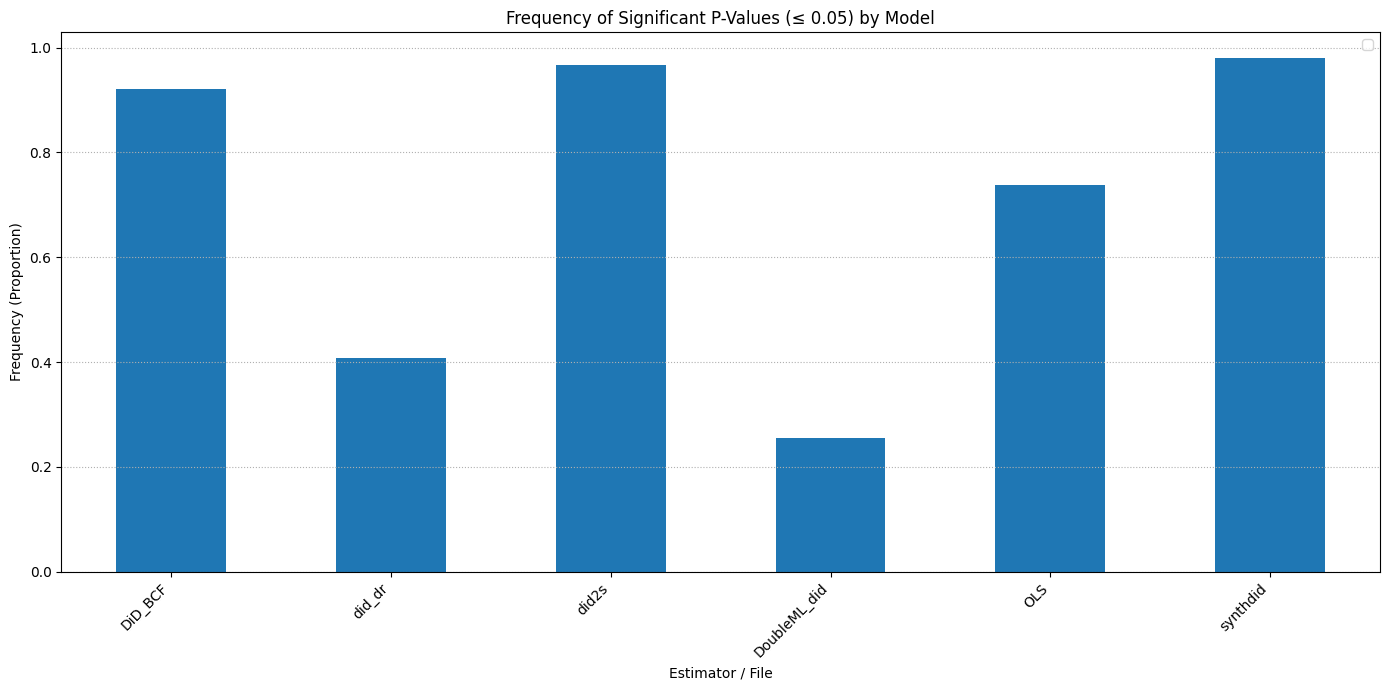

In [3]:
# 0. Define file names and target columns
csv_files = [
    "DiD_BCF_ATE_and_PValues_ATE_linearity=2.csv",
    "did_dr_ATE_and_PValueslinearity_degree=2.csv",
    "did2s_ATE_and_PValueslinearity_degree=2.csv",
    "DoubleML_did_ATE_and_PValueslinearity_degree=2.csv",
    "OLS_ATE_and_PValues_ATE_linearity=2.csv",
    "synthdid_ATE_and_PValueslinearity_degree=2.csv"
]

# Files needing special p-value transformation
transform_files = [
    "DiD_BCF_ATE_and_PValues_ATE_linearity=2.csv",
    "OLS_ATE_and_PValues_ATE_linearity=2.csv"
]

# P-value columns to analyze
p_value_cols_to_analyze = ['PValue_0', 'PValue_1', 'PValue_2', 'PValue_3']

# Dictionary to store results for the final table/graph
frequency_data = {}

# --- Helper function to create cleaner names for display ---
def get_clean_filename(filepath):
    base = os.path.basename(filepath)
    # Remove common suffixes or parts for brevity
    name = base.replace('_ATE_and_PValues_ATE_linearity=2.csv', '')
    name = name.replace('_ATE_and_PValueslinearity_degree=2.csv', '')
    name = name.replace('linearity_degree=2', '') # for DoubleML, did2s, synthdid
    name = name.replace('.csv', '')
    return name

print("Processing files...\n")

# 1. Read and transpose CSVs
for file_path in csv_files:
    try:
        print(f"Reading and transposing: {file_path}")
        # Read the CSV file
        df = pd.read_csv(file_path)
        # Transpose the DataFrame
        df_transposed = df.T
        df_transposed.columns = df_transposed.iloc[0] # Optional: if first row should be header
        # df_transposed = df_transposed[1:]
        # df_transposed = df_transposed.reset_index() # If index is meaningful, otherwise not needed for PValue cols

        # Ensure p-value columns are numeric (they might be read as objects if there are NaNs etc.)
        # And handle cases where PValue columns might not exist in some files after transpose
        # (though the problem implies they should be present)
        for col in p_value_cols_to_analyze:
            if col in df_transposed.columns:
                df_transposed[col] = pd.to_numeric(df_transposed[col], errors='coerce')
            else:
                print(f"Warning: Column {col} not found in transposed {file_path}. Filling with NaNs.")
                df_transposed[col] = pd.NA # Or float('nan')

        # 2. Transform P-Values for specific files
        if file_path in transform_files:
            print(f"Transforming P-Values for: {file_path}")
            for col in p_value_cols_to_analyze:
                if col in df_transposed.columns:
                    # Value > 0.05 becomes 0, otherwise (<= 0.05) becomes 1
                    df_transposed[col] = df_transposed[col].apply(lambda x: 0 if pd.isna(x) or x > 0.05 else 1)
                # No else needed here as we already handled missing columns above

        # Store frequencies for step 3
        clean_name = get_clean_filename(file_path)
        frequency_data[clean_name] = {}

        for col in p_value_cols_to_analyze:
            if col in df_transposed.columns:
                # Calculate frequency of 1s (proportion)
                # Ensure the column is not all NaN after potential coercions
                if df_transposed[col].notna().any():
                    count_of_ones = (df_transposed[col] == 1).sum()
                    total_valid_entries = df_transposed[col].notna().sum()
                    if total_valid_entries > 0:
                        frequency = count_of_ones / total_valid_entries
                    else:
                        frequency = 0.0 # Or pd.NA if you prefer
                else:
                    frequency = 0.0 # Or pd.NA
                frequency_data[clean_name][col] = frequency
            else:
                # This case should ideally not happen if columns were added with NA above
                frequency_data[clean_name][col] = 0.0 # Or pd.NA

    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
    except Exception as e:
        print(f"An error occurred with file {file_path}: {e}")

print("\n--- Processing Complete ---\n")

# 3. Create a table of frequencies
frequency_df_2 = pd.DataFrame.from_dict(frequency_data, orient='index')
# Ensure the columns are in the desired order
frequency_df_2 = frequency_df_2.reindex(columns=p_value_cols_to_analyze, fill_value=0.0)

frequency_df_2=frequency_df_2.mean(axis=1)

print("Frequency Table (Proportion of P-Values <= 0.05):")
print(frequency_df_2)
print("\n")

if not frequency_df_2.empty:
    ax = frequency_df_2.plot(kind='bar', figsize=(14, 7))
    ax.set_title('Frequency of Significant P-Values (≤ 0.05) by Model')
    ax.set_ylabel('Frequency (Proportion)')
    ax.set_xlabel('Estimator / File')
    plt.xticks(rotation=45, ha='right') # Rotate x-labels for better readability
    plt.legend(title='')
    plt.grid(axis='y', linestyle=':')
    plt.tight_layout() # Adjust layout to make room for labels
    plt.show()
else:
    print("No data to plot.")

Processing files...

Reading and transposing: DiD_BCF_ATE_and_PValues_ATE_linearity=3.csv
Transforming P-Values for: DiD_BCF_ATE_and_PValues_ATE_linearity=3.csv
Reading and transposing: did_dr_ATE_and_PValueslinearity_degree=3.csv
Reading and transposing: did2s_ATE_and_PValueslinearity_degree=3.csv
Reading and transposing: DoubleML_did_ATE_and_PValueslinearity_degree=3.csv
Reading and transposing: OLS_ATE_and_PValues_ATE_linearity=3.csv
Transforming P-Values for: OLS_ATE_and_PValues_ATE_linearity=3.csv
Reading and transposing: synthdid_ATE_and_PValueslinearity_degree=3.csv

--- Processing Complete ---

Frequency Table (Proportion of P-Values <= 0.05):
DiD_BCF         0.970297
did_dr          0.877500
did2s           0.997500
DoubleML_did    0.690000
OLS             0.737624
synthdid        1.000000
dtype: float64




/tmp/ipykernel_17794/1283423118.py:112: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='')


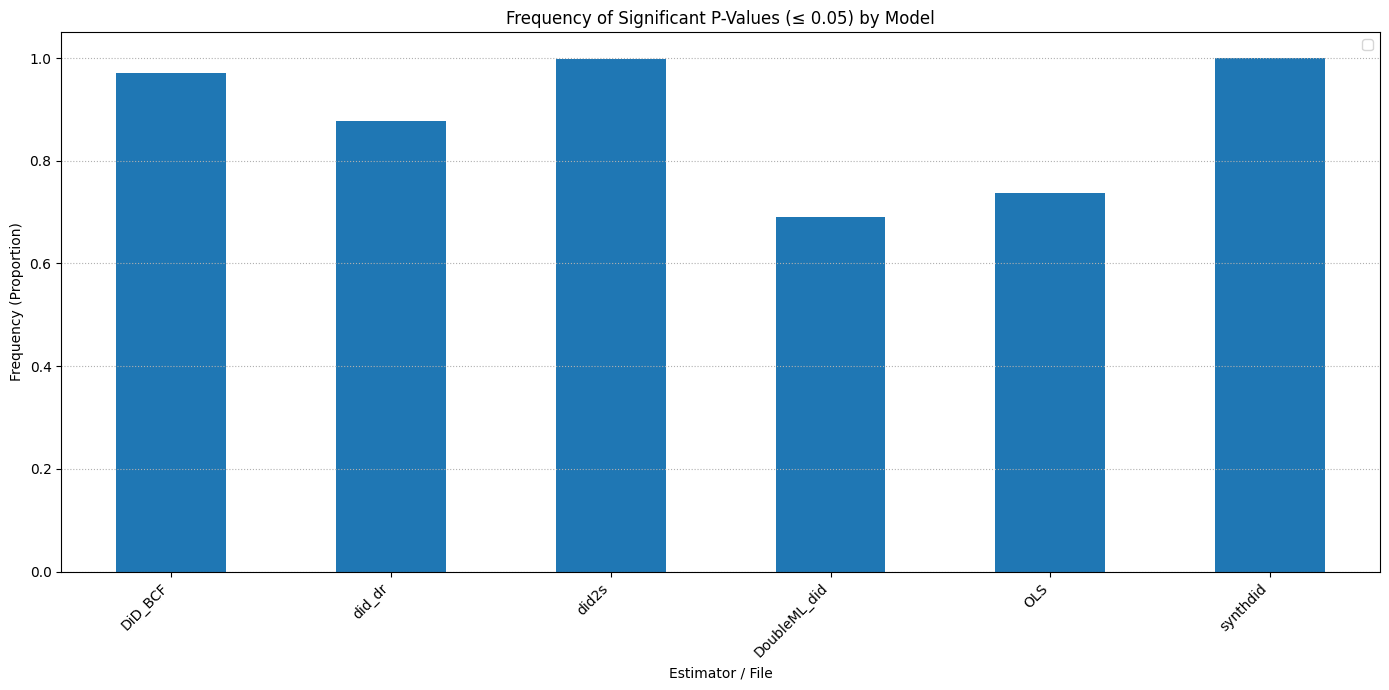

In [4]:
# 0. Define file names and target columns
csv_files = [
    "DiD_BCF_ATE_and_PValues_ATE_linearity=3.csv",
    "did_dr_ATE_and_PValueslinearity_degree=3.csv",
    "did2s_ATE_and_PValueslinearity_degree=3.csv",
    "DoubleML_did_ATE_and_PValueslinearity_degree=3.csv",
    "OLS_ATE_and_PValues_ATE_linearity=3.csv",
    "synthdid_ATE_and_PValueslinearity_degree=3.csv"
]

# Files needing special p-value transformation
transform_files = [
    "DiD_BCF_ATE_and_PValues_ATE_linearity=3.csv",
    "OLS_ATE_and_PValues_ATE_linearity=3.csv"
]

# P-value columns to analyze
p_value_cols_to_analyze = ['PValue_0', 'PValue_1', 'PValue_2', 'PValue_3']

# Dictionary to store results for the final table/graph
frequency_data = {}

# --- Helper function to create cleaner names for display ---
def get_clean_filename(filepath):
    base = os.path.basename(filepath)
    # Remove common suffixes or parts for brevity
    name = base.replace('_ATE_and_PValues_ATE_linearity=3.csv', '')
    name = name.replace('_ATE_and_PValueslinearity_degree=3.csv', '')
    name = name.replace('linearity_degree=3', '') # for DoubleML, did2s, synthdid
    name = name.replace('.csv', '')
    return name

print("Processing files...\n")

# 1. Read and transpose CSVs
for file_path in csv_files:
    try:
        print(f"Reading and transposing: {file_path}")
        # Read the CSV file
        df = pd.read_csv(file_path)
        # Transpose the DataFrame
        df_transposed = df.T
        df_transposed.columns = df_transposed.iloc[0] # Optional: if first row should be header
        # df_transposed = df_transposed[1:]
        # df_transposed = df_transposed.reset_index() # If index is meaningful, otherwise not needed for PValue cols

        # Ensure p-value columns are numeric (they might be read as objects if there are NaNs etc.)
        # And handle cases where PValue columns might not exist in some files after transpose
        # (though the problem implies they should be present)
        for col in p_value_cols_to_analyze:
            if col in df_transposed.columns:
                df_transposed[col] = pd.to_numeric(df_transposed[col], errors='coerce')
            else:
                print(f"Warning: Column {col} not found in transposed {file_path}. Filling with NaNs.")
                df_transposed[col] = pd.NA # Or float('nan')

        # 2. Transform P-Values for specific files
        if file_path in transform_files:
            print(f"Transforming P-Values for: {file_path}")
            for col in p_value_cols_to_analyze:
                if col in df_transposed.columns:
                    # Value > 0.05 becomes 0, otherwise (<= 0.05) becomes 1
                    df_transposed[col] = df_transposed[col].apply(lambda x: 0 if pd.isna(x) or x > 0.05 else 1)
                # No else needed here as we already handled missing columns above

        # Store frequencies for step 3
        clean_name = get_clean_filename(file_path)
        frequency_data[clean_name] = {}

        for col in p_value_cols_to_analyze:
            if col in df_transposed.columns:
                # Calculate frequency of 1s (proportion)
                # Ensure the column is not all NaN after potential coercions
                if df_transposed[col].notna().any():
                    count_of_ones = (df_transposed[col] == 1).sum()
                    total_valid_entries = df_transposed[col].notna().sum()
                    if total_valid_entries > 0:
                        frequency = count_of_ones / total_valid_entries
                    else:
                        frequency = 0.0 # Or pd.NA if you prefer
                else:
                    frequency = 0.0 # Or pd.NA
                frequency_data[clean_name][col] = frequency
            else:
                # This case should ideally not happen if columns were added with NA above
                frequency_data[clean_name][col] = 0.0 # Or pd.NA

    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
    except Exception as e:
        print(f"An error occurred with file {file_path}: {e}")

print("\n--- Processing Complete ---\n")

# 3. Create a table of frequencies
frequency_df_3 = pd.DataFrame.from_dict(frequency_data, orient='index')
# Ensure the columns are in the desired order
frequency_df_3 = frequency_df_3.reindex(columns=p_value_cols_to_analyze, fill_value=0.0)

frequency_df_3=frequency_df_3.mean(axis=1)

print("Frequency Table (Proportion of P-Values <= 0.05):")
print(frequency_df_3)
print("\n")

if not frequency_df_3.empty:
    ax = frequency_df_3.plot(kind='bar', figsize=(14, 7))
    ax.set_title('Frequency of Significant P-Values (≤ 0.05) by Model')
    ax.set_ylabel('Frequency (Proportion)')
    ax.set_xlabel('Estimator / File')
    plt.xticks(rotation=45, ha='right') # Rotate x-labels for better readability
    plt.legend(title='')
    plt.grid(axis='y', linestyle=':')
    plt.tight_layout() # Adjust layout to make room for labels
    plt.show()
else:
    print("No data to plot.")

In [5]:
import numpy as np

In [6]:
def create_merged_df(setting1, setting2, setting3):
    """
    Creates a pandas DataFrame from three numerical arrays,
    using specified row and column labels.

    Args:
        setting1: NumPy array for the first setting.
        setting2: NumPy array for the second setting (with method names).
        setting3: NumPy array for the third setting.

    Returns:
        A pandas DataFrame, or None if input is invalid.
    """

    # Input validation: Check for NumPy arrays and correct lengths.
    if not all(isinstance(arr, np.ndarray) for arr in [setting1, setting2, setting3]):
        print("Error: All inputs must be NumPy arrays.")
        return None

    # Define row labels (method names)
    method_names = ["DiD_BCF", "did_dr", "did2s", "DoubleML_did", "OLS", "synthdid"]

    # Ensure all inputs are of compatible size. If they are not, they must be resized
    # or padded for them to work together
    len_setting2 = len(setting2)
    if len(setting2) > len(method_names):
        print("Error: setting2 has more rows than method_names.  Cannot create DataFrame.")
        return None
    
    if len(method_names) > len(setting2):
        # pad setting2 with nans, which will create a dataframe with the number of method names rows
        padding_size = len(method_names) - len(setting2)
        setting2 = np.pad(setting2, (0, padding_size), 'constant', constant_values=np.nan)

    # Convert the arrays into a list of lists to put inside of the dataframe
    data = [setting1[:len_setting2], setting2, setting3[:len_setting2]]

    # Create the DataFrame
    try:
        df = pd.DataFrame(data=data,
                            index=["Setting 1", "Setting 2", "Setting 3"],
                            columns=method_names)
        return df
    except Exception as e:
        print(f"Error creating DataFrame: {e}")
        return None


frequency_df = create_merged_df(np.array(frequency_df_1), np.array(frequency_df_2), np.array(frequency_df_3)).T


Frequency Table (Proportion of P-Values <= 0.05):
              Setting 1  Setting 2  Setting 3
DiD_BCF        0.990099   0.920792   0.970297
did_dr         0.990000   0.407500   0.877500
did2s          1.000000   0.967500   0.997500
DoubleML_did   0.862500   0.255000   0.690000
OLS            0.990099   0.737624   0.737624
synthdid       1.000000   0.980000   1.000000




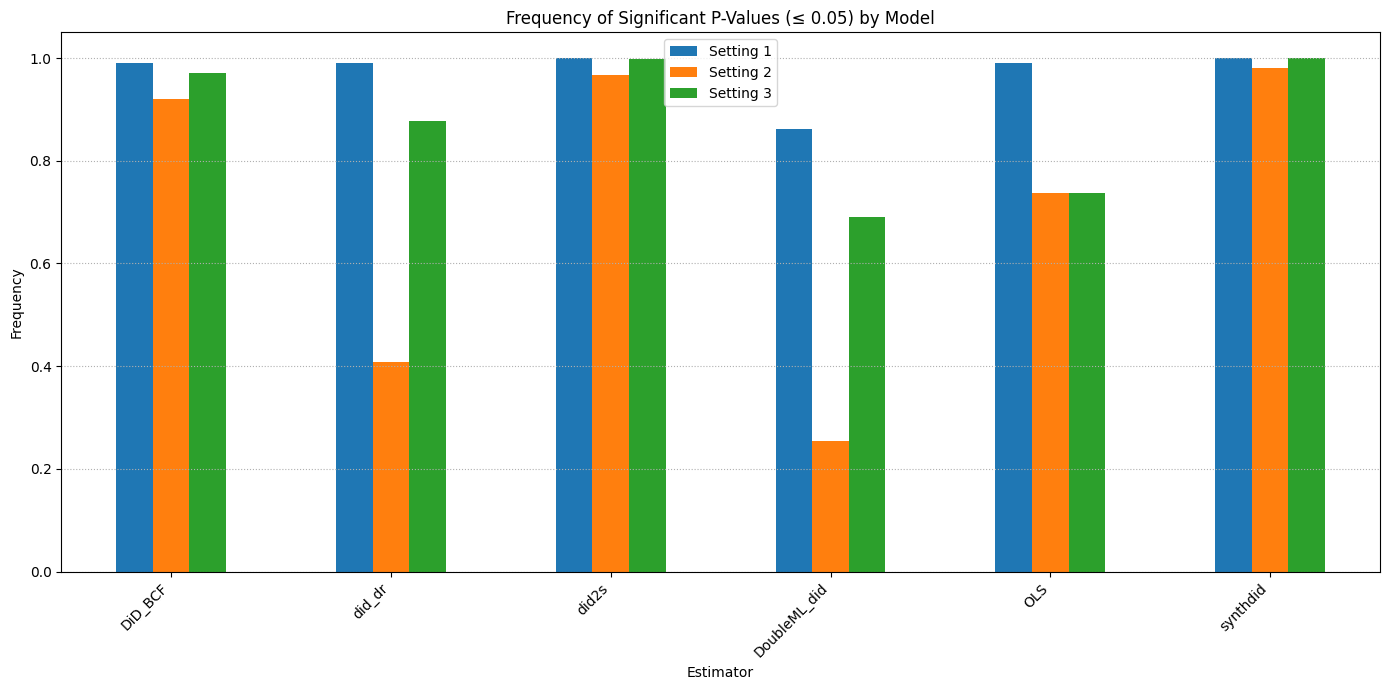

In [7]:
print("Frequency Table (Proportion of P-Values <= 0.05):")
print(frequency_df)
print("\n")

if not frequency_df.empty:
    ax = frequency_df.plot(kind='bar', figsize=(14, 7))
    ax.set_title('Frequency of Significant P-Values (≤ 0.05) by Model')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Estimator')
    plt.xticks(rotation=45, ha='right') # Rotate x-labels for better readability
    plt.legend(title='')
    plt.grid(axis='y', linestyle=':')
    plt.tight_layout() # Adjust layout to make room for labels
    plt.show()
else:
    print("No data to plot.")